In [5]:
import pandas as pd
import numpy as np
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.model_selection import train_test_split
from itertools import product
import warnings
warnings.filterwarnings("ignore")

In [43]:
# Load and preprocess the data
df = pd.read_csv("NewFactOrder.csv")
df['DateOrderedKey'] = pd.to_datetime(df['DateOrderedKey'], format='%Y%m%d')
df['Month'] = df['DateOrderedKey'].dt.to_period('M')
df = df[['QuantityOrdered', 'ArticleGroupName', 'Month']].dropna()
df_grouped = df.groupby(['ArticleGroupName', 'Month']).sum().reset_index()
pivot_table = df_grouped.pivot(index='Month', columns='ArticleGroupName', values='QuantityOrdered').fillna(0)

In [ ]:
#pivot_table.drop(pivot_table.columns[[4,5,11,12,14]], axis=1, inplace=True)

In [44]:
pivot_table

ArticleGroupName,ACCESSORIES,BODY AND ONESIE,BOTTOMS,DRESSES,Discount,ECOM return cost,Giftwrapping,HATS,HOME,OUTERWEAR,SWIMWEAR,Shipment,Stuff,TOPS,Övriga intäkter
Month,,,,,,,,,,,,,,,
2018-01,256.0,1074.0,6144.0,2958.0,0.0,0.0,0.0,1133.0,82.0,406.0,16.0,2.0,0.0,4973.0,19.0
2018-02,283.0,775.0,4118.0,2184.0,0.0,0.0,0.0,1562.0,71.0,383.0,11.0,1.0,0.0,4108.0,1.0
2018-03,247.0,402.0,1336.0,513.0,0.0,0.0,0.0,531.0,88.0,612.0,451.0,2.0,66.0,2390.0,22.0
2018-04,470.0,242.0,631.0,194.0,0.0,0.0,0.0,504.0,42.0,413.0,220.0,2.0,12.0,1125.0,11.0
2018-05,297.0,298.0,1106.0,468.0,0.0,0.0,0.0,831.0,214.0,366.0,244.0,0.0,11.0,2008.0,0.0
2018-06,225.0,1000.0,2978.0,1260.0,0.0,0.0,0.0,801.0,133.0,298.0,140.0,1.0,11.0,4786.0,0.0
2018-07,305.0,1299.0,3908.0,1994.0,0.0,0.0,0.0,1274.0,79.0,652.0,642.0,0.0,19.0,5944.0,17.0
2018-08,595.0,1136.0,3944.0,1823.0,0.0,0.0,0.0,1676.0,110.0,1228.0,320.0,0.0,22.0,5045.0,4.0
2018-09,733.0,230.0,761.0,180.0,0.0,1.0,0.0,558.0,3816.0,644.0,38.0,1.0,13.0,1604.0,8.0


In [45]:
# Split the data into training and testing sets
train_size = int(len(pivot_table) * 0.7)
train_data, test_data = pivot_table[:train_size], pivot_table[train_size:]

In [46]:
# Grid search for hyperparameter tuning
best_model = None
best_mape = float('inf')

In [47]:
for p, d, q in product(range(3), range(2), range(3)):
    try:
        mape_values = []
        for column in train_data.columns:
            model = ARIMA(train_data[column], order=(p, d, q))
            model_fit = model.fit()
            predicted_values = model_fit.predict(start=test_data.index[0], end=test_data.index[-1])
            mape = mean_absolute_percentage_error(test_data[column], predicted_values)
            mape_values.append(mape)

        avg_mape = np.mean(mape_values)
        if avg_mape < best_mape:
            best_model = (p, d, q)
            best_mape = avg_mape
    except:
        continue

In [48]:
# Fit the best model and make predictions
predicted_values = pd.DataFrame()
for column in pivot_table.columns:
    model = ARIMA(pivot_table[column], order=best_model)
    model_fit = model.fit()
    predicted_values[column] = model_fit.predict(start=pivot_table.index[0], end=pivot_table.index[-1])

In [49]:
# Calculate MAPE for the best model
mape = mean_absolute_percentage_error(pivot_table, predicted_values)

print("MAPE for the best model:", mape)

MAPE for the best model: 1.7811533661402236e+16


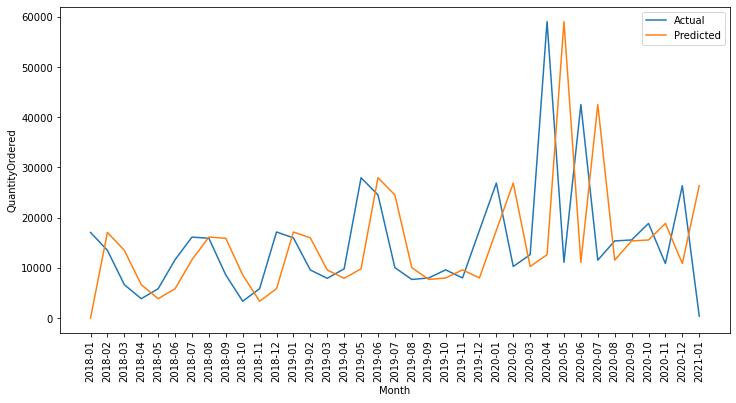

In [50]:
# Plot actual vs predicted values
plt.figure(figsize=(12, 6))
plt.plot(pivot_table.index.astype(str), pivot_table.sum(axis=1), label='Actual')
plt.plot(pivot_table.index.astype(str), predicted_values.sum(axis=1), label='Predicted')
plt.xticks(rotation = 90)
plt.xlabel('Month')
plt.ylabel('QuantityOrdered')
plt.legend()
plt.show()

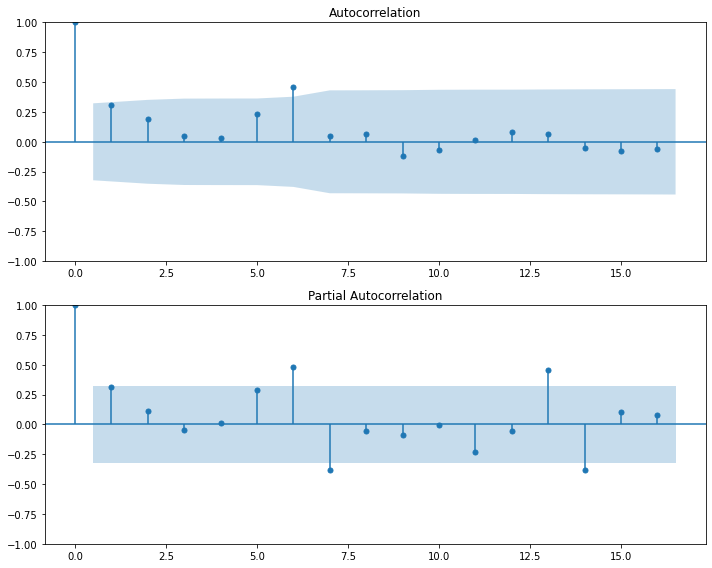

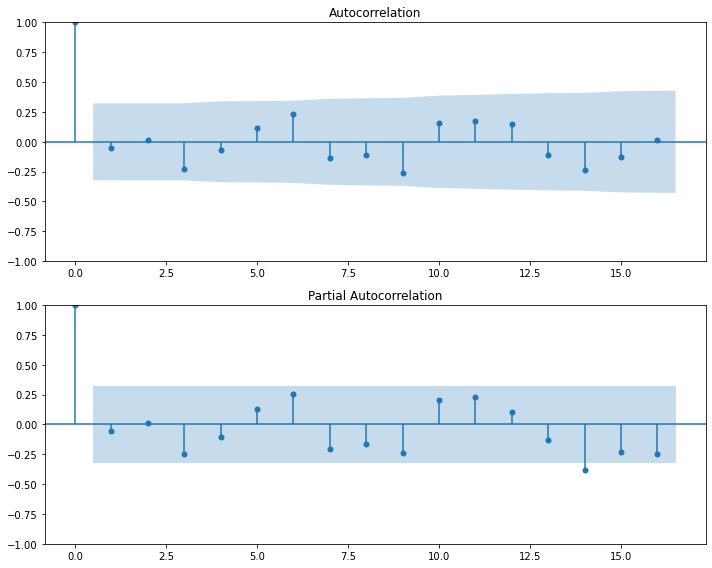

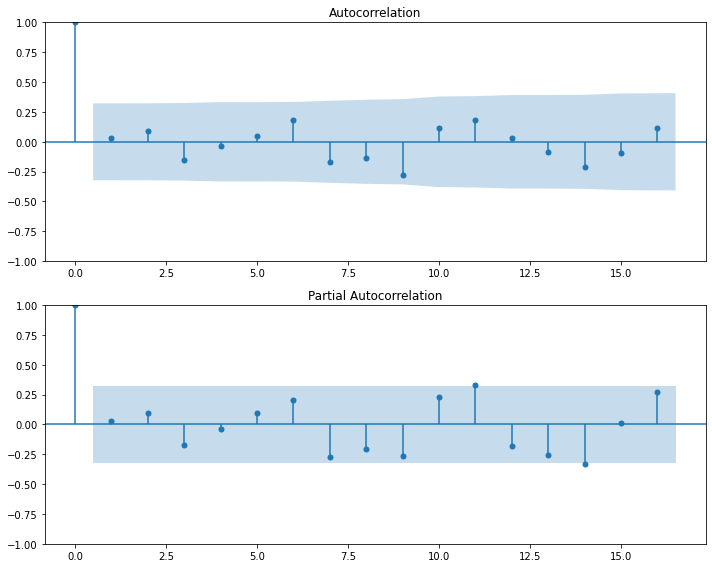

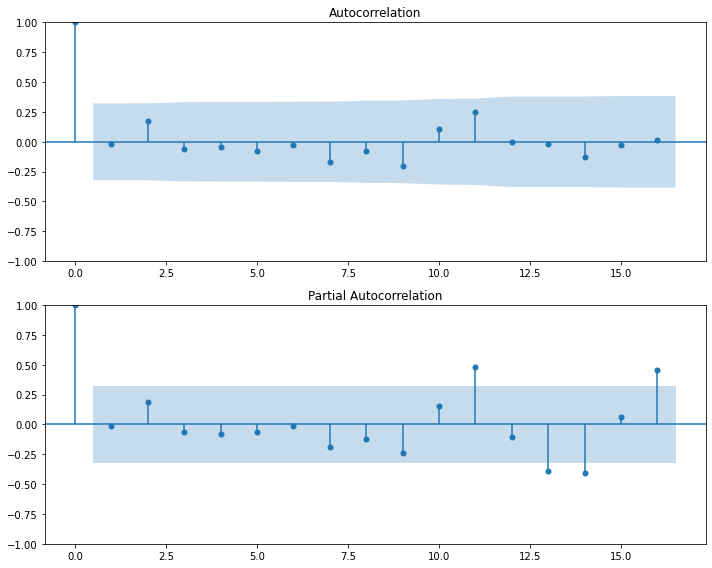

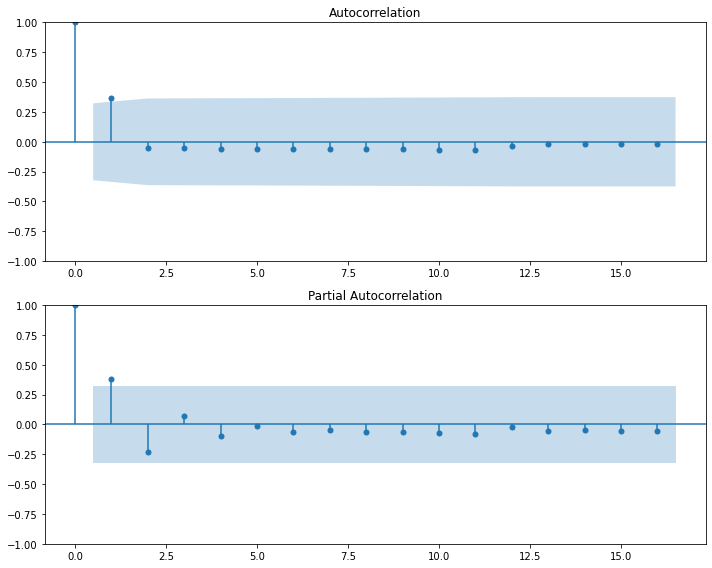

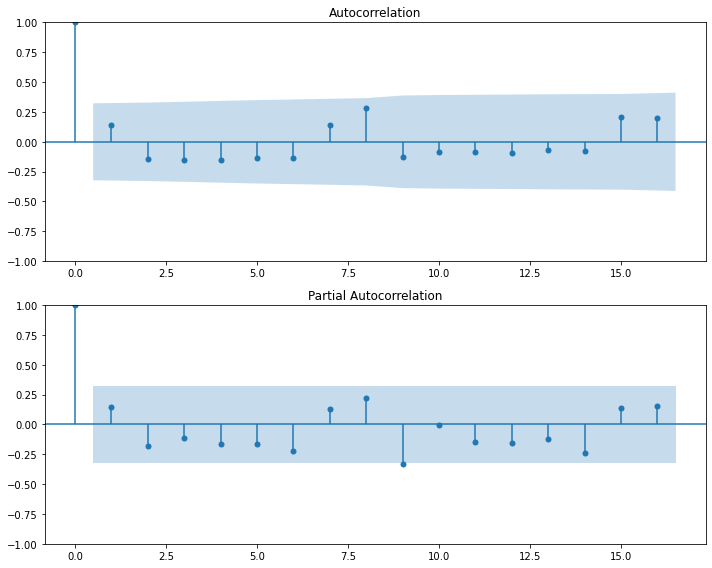

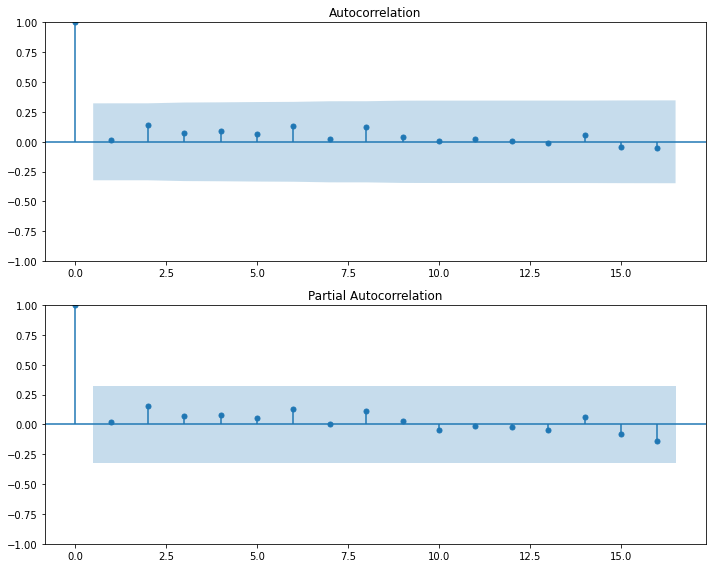

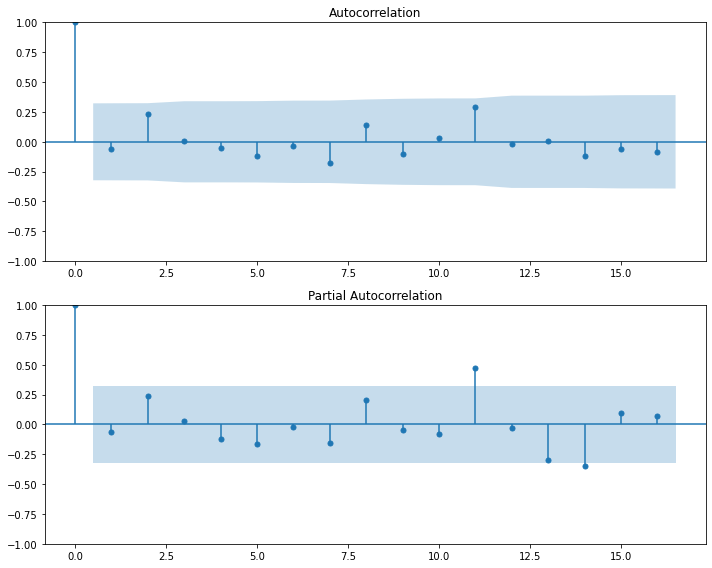

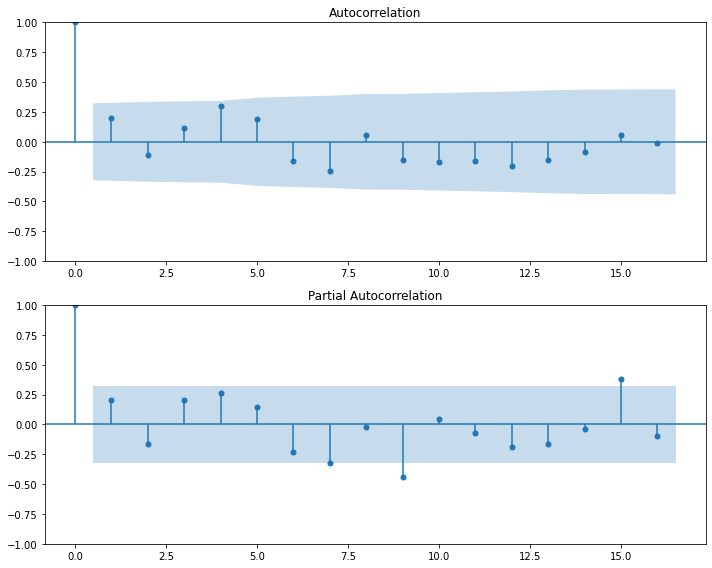

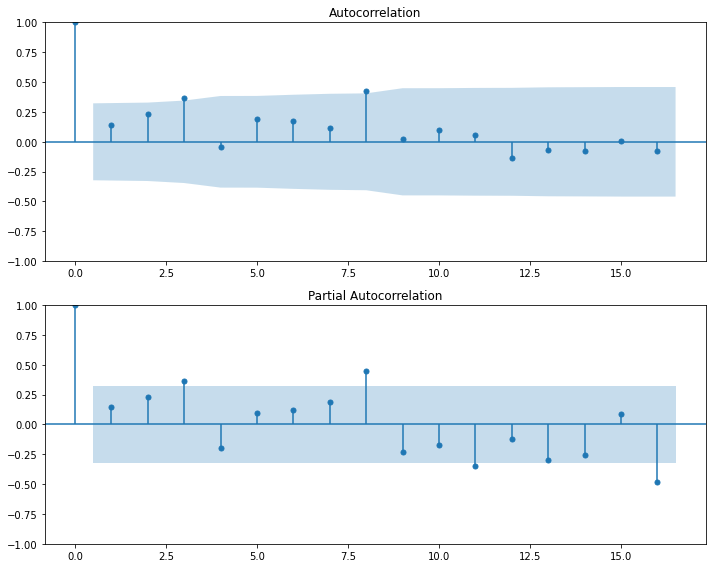

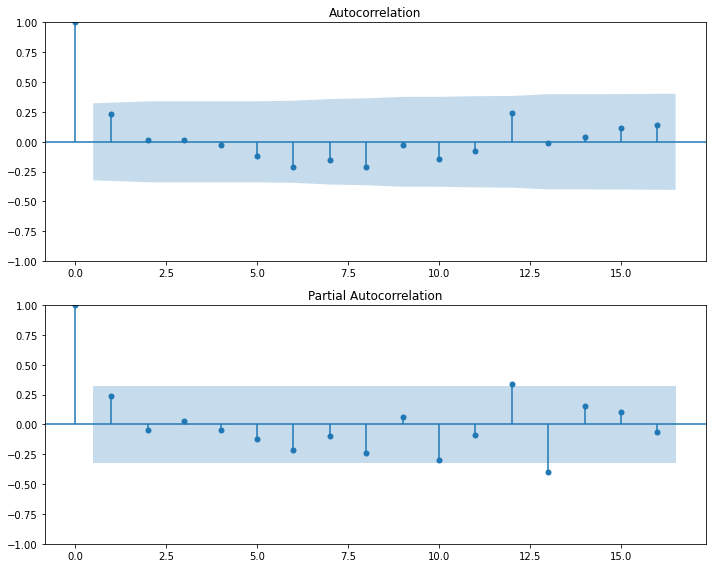

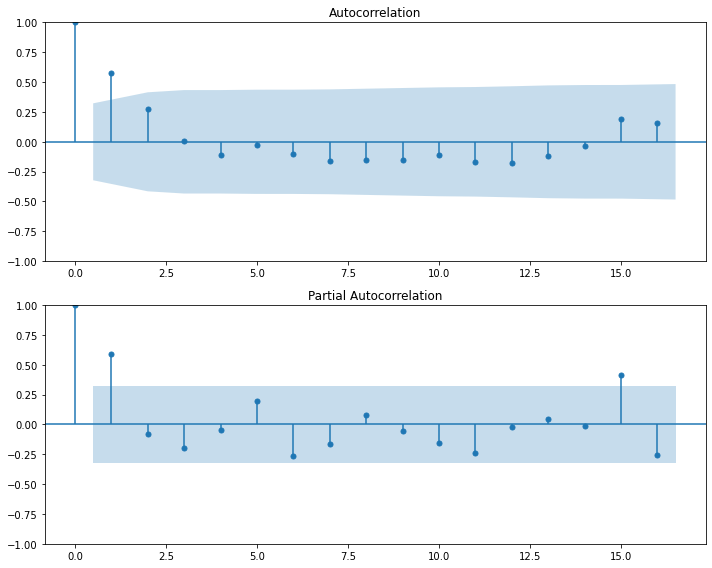

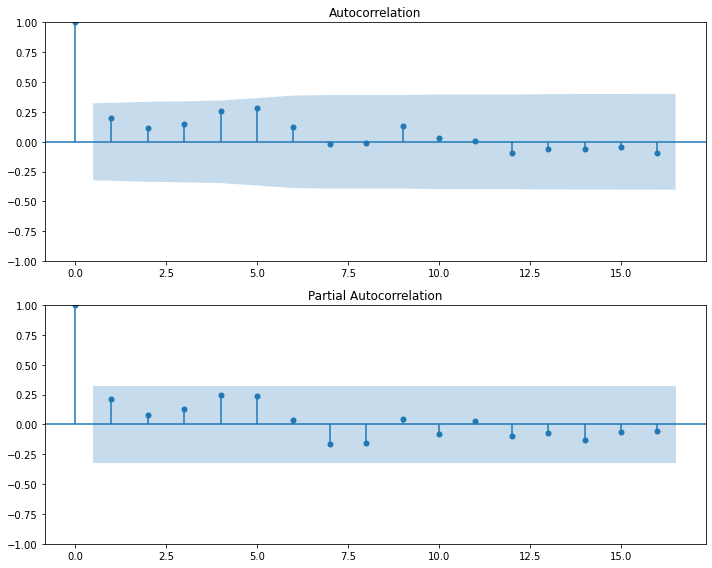

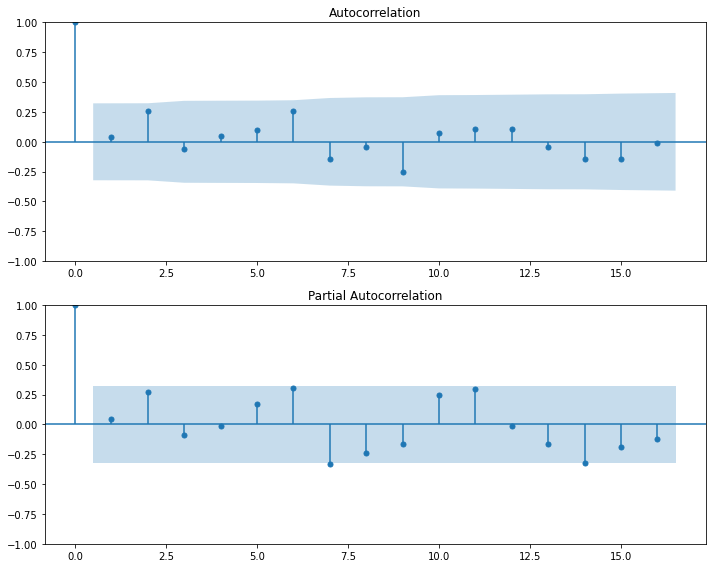

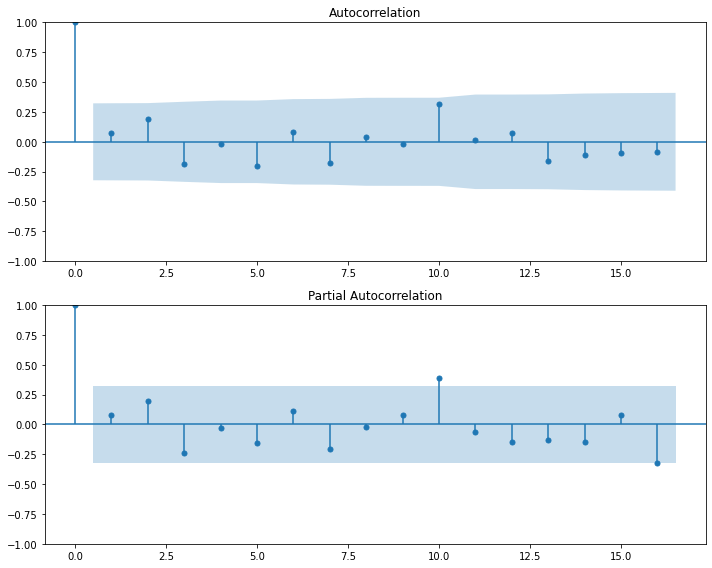

In [51]:
# Plot ACF and PACF for each column separately
for column in pivot_table.columns:
    fig, axes = plt.subplots(2, 1, figsize=(10, 8))
    plot_acf(pivot_table[column], ax=axes[0])
    plot_pacf(pivot_table[column], ax=axes[1])
    plt.tight_layout()
    plt.show()


In [52]:
# Calculate MAPE for the best model
mape = mean_absolute_percentage_error(pivot_table, predicted_values)
print("MAPE for the best model:", mape)

# Print the AIC and BIC values
print("AIC value:", model_fit.aic)
print("BIC value:", model_fit.bic)

MAPE for the best model: 1.7811533661402236e+16
AIC value: 322.53186286801997
BIC value: 324.1153818064761


In [53]:
predicted_values

,ACCESSORIES,BODY AND ONESIE,BOTTOMS,DRESSES,Discount,ECOM return cost,Giftwrapping,HATS,HOME,OUTERWEAR,SWIMWEAR,Shipment,Stuff,TOPS,Övriga intäkter
Month,,,,,,,,,,,,,,,
2018-01,0.0,0.0,0.0,0.0,0.000000e+00,0.000000e+00,0.0,0.0,0.0,0.0,0.0,0.000000e+00,0.000000e+00,0.0,0.000000e+00
2018-02,256.0,1074.0,6144.0,2958.0,0.000000e+00,0.000000e+00,0.0,1133.0,82.0,406.0,16.0,2.000000e+00,0.000000e+00,4973.0,1.900000e+01
2018-03,283.0,775.0,4118.0,2184.0,0.000000e+00,0.000000e+00,0.0,1562.0,71.0,383.0,11.0,1.000000e+00,0.000000e+00,4108.0,1.000000e+00
2018-04,247.0,402.0,1336.0,513.0,0.000000e+00,0.000000e+00,0.0,531.0,88.0,612.0,451.0,2.000000e+00,6.600000e+01,2390.0,2.200000e+01
2018-05,470.0,242.0,631.0,194.0,0.000000e+00,0.000000e+00,0.0,504.0,42.0,413.0,220.0,2.000000e+00,1.200000e+01,1125.0,1.100000e+01
2018-06,297.0,298.0,1106.0,468.0,0.000000e+00,0.000000e+00,0.0,831.0,214.0,366.0,244.0,0.000000e+00,1.100000e+01,2008.0,0.000000e+00
2018-07,225.0,1000.0,2978.0,1260.0,0.000000e+00,0.000000e+00,0.0,801.0,133.0,298.0,140.0,1.000000e+00,1.100000e+01,4786.0,0.000000e+00
2018-08,305.0,1299.0,3908.0,1994.0,0.000000e+00,0.000000e+00,0.0,1274.0,79.0,652.0,642.0,0.000000e+00,1.900000e+01,5944.0,1.700000e+01
2018-09,595.0,1136.0,3944.0,1823.0,0.000000e+00,0.000000e+00,0.0,1676.0,110.0,1228.0,320.0,0.000000e+00,2.200000e+01,5045.0,4.000000e+00
